# Benchmark Speed Analysis

Launch the script with logging to capture benchmark data:
```bash
benchmark.sh 2>&1 | tee benchmark.txt
```



In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import re
import tempfile
sns.set_theme(style="whitegrid")


In [2]:
BENCHMARK_FILE = os.path.expanduser('~/data/2025_benchmark/benchmark.txt')

In [3]:
def parse_benchmark_file(file_path):
    results = []
    current_block = None
    in_job_section = False
    current_job = None

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            # Start of a new bam block
            if re.match('^bams[1-5]$', line.strip()):
                current_stats = []
                current_block = {'name': line, 'stats': current_stats}
                results.append(current_block)
                in_job_section = False
                continue

            # Start of job stats section
            if line.startswith('Job stats:'):
                in_job_section = True
                current_job = {}
                current_stats.append(current_job)
                continue

            # Handle stats section
            if in_job_section:
                if line.startswith('total'):
                    in_job_section = False
                elif line.startswith("call_"):
                    current_job['name'] = line.split(' ')[0]
                continue

            # Look for real time
            if line.startswith('real'):
                if 'real_time' not in current_job:
                    current_job['real_time'] = re.sub(',[0-9]+', '', line.split('\t')[1].strip())
                continue

    return results

In [4]:
results = parse_benchmark_file(BENCHMARK_FILE)
results

[{'name': 'bams1',
  'stats': [{'name': 'call_peaks_macs2', 'real_time': '0m59s'},
   {'name': 'call_peaks_macs2', 'real_time': '1m10s'},
   {'name': 'call_peaks_sicer', 'real_time': '4m14s'},
   {'name': 'call_peaks_span', 'real_time': '6m18s'},
   {'name': 'call_peaks_macs3', 'real_time': '1m29s'},
   {'name': 'call_peaks_macs3', 'real_time': '1m38s'},
   {'name': 'call_peaks_sicer2', 'real_time': '0m54s'},
   {'name': 'call_peaks_homer', 'real_time': '1m2s'},
   {'real_time': '0m9s'},
   {'name': 'call_peaks_peakseq', 'real_time': '11m31s'},
   {'name': 'call_peaks_fseq2', 'real_time': '1m59s'},
   {'name': 'call_peaks_lanceotron', 'real_time': '14m2s'}]},
 {'name': 'bams2',
  'stats': [{'name': 'call_peaks_macs2', 'real_time': '1m8s'},
   {'name': 'call_peaks_macs2', 'real_time': '1m8s'},
   {'name': 'call_peaks_sicer', 'real_time': '6m14s'},
   {'name': 'call_peaks_span', 'real_time': '7m24s'},
   {'name': 'call_peaks_macs3', 'real_time': '1m41s'},
   {'name': 'call_peaks_macs3', 

In [5]:
rows = []
for block in results:
    name = block['name']
    for job in block['stats']:
        if 'name' not in job:
            continue
        peak_caller = job['name'].replace('call_peaks_', '')
        real_time = job['real_time']
        time = re.split('[ms]', real_time)
        time_sec = 60 * int(time[0]) + int(time[1])
        rows.append((name, peak_caller, time_sec))
    rows.append((name, 'bayespeak', 1.5 * 60 * 60))  # 1.5 hours
    rows.append((name, 'gps', 2 * 60 * 60))  # 2 hours

df = pd.DataFrame(rows, columns=['block', 'tool', 'time'])
df.loc[df['tool'] == 'macs2', 'tool'] = 'MACS2'
df.loc[df['tool'] == 'macs3', 'tool'] = 'MACS3'
df.loc[df['tool'] == 'sicer', 'tool'] = 'SICER'
df.loc[df['tool'] == 'sicer2', 'tool'] = 'SICER2'
df.loc[df['tool'] == 'homer', 'tool'] = 'HOMER'
df.loc[df['tool'] == 'hotspot', 'tool'] = 'Hotspot'
df.loc[df['tool'] == 'peakseq', 'tool'] = 'Peakseq'
df.loc[df['tool'] == 'omnipeak', 'tool'] = 'Omnipeak'
df.loc[df['tool'] == 'bayespeak', 'tool'] = 'BayesPeak'
df.loc[df['tool'] == 'gps', 'tool'] = 'GPS'
df.loc[df['tool'] == 'lanceotron', 'tool'] = 'LanceOtron'
df

,block,tool,time
0,bams1,MACS2,59.0
1,bams1,MACS2,70.0
2,bams1,SICER,254.0
3,bams1,Omnipeak,378.0
4,bams1,MACS3,89.0
...,...,...,...
75,bams4,BayesPeak,5400.0
76,bams4,GPS,7200.0
77,bams5,Hotspot,55.0
78,bams5,BayesPeak,5400.0


In [6]:
df['tool'].unique()

array(['MACS2', 'SICER', 'Omnipeak', 'MACS3', 'SICER2', 'HOMER',
       'Peakseq', 'fseq2', 'LanceOtron', 'BayesPeak', 'GPS', 'Hotspot'],
      dtype=object)

In [7]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'Peakseq', 'LanceOtron', 'Omnipeak']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

TOOLS_OTHER = ['MACS3', 'SICER2', 'BayesPeak', 'GPS']
palette = plt.get_cmap('tab20')
for i, tool in enumerate(TOOLS_OTHER):
    TOOLS_PALETTE[tool] = palette(19 - i)

# Tools by speed
# TOOLS = ['MACS2', 'SICER2', 'HOMER', 'MACS3', 'Hotspot', 'SICER', 'Omnipeak', 'Peakseq', 'BayesPeak', 'GPS', 'LanceOtron']
TOOLS = ['MACS2', 'HOMER', 'Hotspot', 'SICER', 'Omnipeak', 'Peakseq', 'LanceOtron', 'BayesPeak', 'GPS']

Time


/tmp/ipykernel_672528/3033207814.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_results = sns.barplot(data=df, x='tool', y='time',


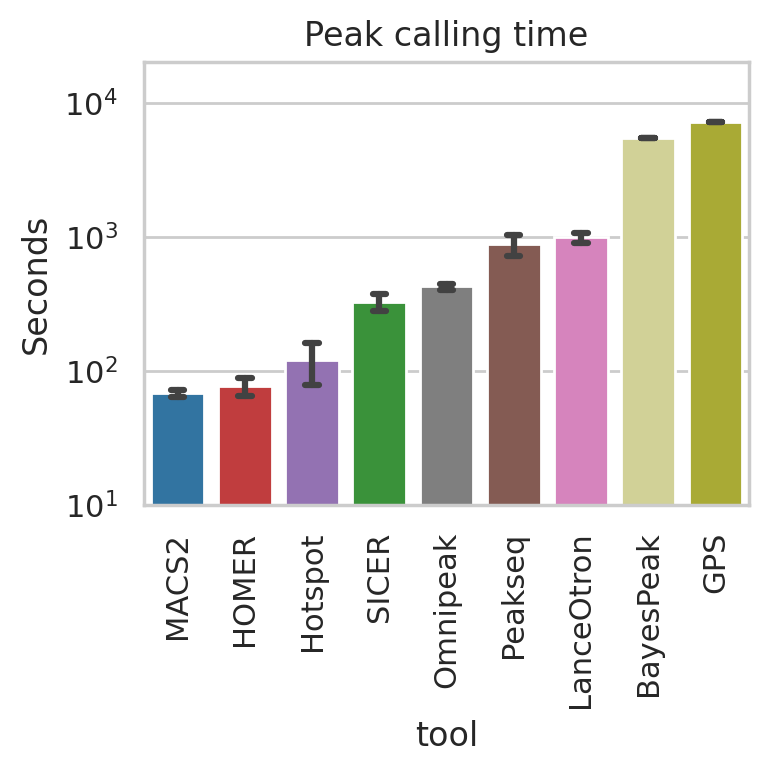

In [8]:
print('Time')
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peak calling time')
g_results = sns.barplot(data=df, x='tool', y='time',
                        order=TOOLS,
                        palette=TOOLS_PALETTE,
                        capsize=.2,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set(yscale='log')
ax.set_ylim((10, 2e4))
ax.set_ylabel('Peak caller')
ax.set_ylabel('Seconds')
plt.tight_layout()
plt.show()